In [ ]:
#I dont know how well will this code work here because I just saw that we needed the jupyter code, and I had done all my code in colab
import pandas as pd
import requests #library needed for requesting information from website
import re #library for getting only certain data from category

#change long data to short, easy to read one
def normalize_drive_type(val):
    if not val:
        return "Unknown"
    val = val.lower()
    if "front" in val:
        return "FWD"
    elif "rear" in val:
        return "RWD"
    elif "all" in val or "4wd" in val or "awd" in val:
        return "AWD"
    return val.upper()

def normalize_body_class(val):
    if not val:
        return "Unknown"
    val = val.lower()
    if "sport utility" in val or "mpv" in val or "suv" in val:
        return "SUV"
    elif "sedan" in val:
        return "Sedan"
    elif "coupe" in val:
        return "Coupe"
    elif "convertible" in val:
        return "Convertible"
    elif "truck" in val or "pickup" in val:
        return "Truck"
    elif "van" in val:
        return "Van"
    else:
        return val.capitalize()

#decoding vin using the NHTSA vin decoder site
def decode_vin(vin):
    url = f"https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVin/{vin}?format=json"

    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json()

            # columns for vehicle specs in each row
            specs = {
                "Model": None,
                "Trim": None,
                "Engine Displacement (L)": None,
                "Gross Vehicle Weight Rating": None,
                "Cylinders": None,
                "Drive Type": None,
                "fueltype": None,
                "Body Class": None
            }

            # loop through the results
            for item in data['Results']:
                var = item['Variable']
                val = item['Value']

                # model
                if var == "Model" and val:
                    specs["Model"] = val

                # trim
                if var == "Trim" and val:
                    specs["Trim"] = val

                # displacement of engine converted to float
                if var == "Displacement (L)" and val:
                    try:
                        specs["Engine Displacement (L)"] = float(val)
                    except:
                        pass  # In case conversion fails, ignore

                #extract cylinders
                if var == "Engine Number of Cylinders" and val:
                    specs["Cylinders"] = val

                # use normalizE and extact the drive type
                if var == "Drive Type" and val:
                    specs["Drive Type"] = normalize_drive_type(val)

                #extract fuel type
                if var == "Fuel Type - Primary" and val:
                    specs["fueltype"] = val

                # extract weight class
                if var == "Gross Vehicle Weight Rating" and val:
                    specs["Gross Vehicle Weight Rating"] = val

                #use the normalize and extract
                if var == "Body Class" and val:
                    specs["Body Class"] = normalize_body_class(val)

            return specs


    #return original if decoding fails - no data found
    return {
        "Model": "Unknown",
        "Trim": "Unknown",
        "Engine Displacement (L)": None,
        "Gross Vehicle Weight Rating": "Unknown",
        "Cylinders": "Unknown",
        "Drive Type": "Unknown",
        "fueltype": "Unknown",
        "Body Class": "Unknown"
    }

#original dataset
file_path = "/content/drive/My Drive/USA_cars_datasets.csv"
df = pd.read_csv(file_path)

# vin decoding function to each vin
vin_data = df['vin'].apply(decode_vin).apply(pd.Series)

#concat original and new data done by column
df = pd.concat([df, vin_data], axis=1)

df_clean = df.dropna()
df_clean = df_clean[~df_clean.apply(lambda row: row.astype(str).str.lower().str.contains('unknown').any(), axis=1)]

# save
output_path = "/content/drive/My Drive/detailscut.xlsx"
df.to_excel(output_path, index=False, engine='openpyxl')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('detailscut.xlsx')

#clean the numeric columns
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

#keeping data that seems more realistic
df = df[(df['price'] > 1000) & (df['mileage'] > 0) & (df['year'] > 1980)] 

#make age from dataset - year
df['age'] = 2025 - df['year']

#1. price vs mileage visual
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='mileage', y='price', scatter_kws={'alpha':0.3}, line_kws={"color":"red"}) #regression line
plt.ylim(0, df['price'].quantile(0.98))  
plt.xlim(0, df['mileage'].quantile(0.98)) #limit to show area with most cars, not include those out of the area on the visual><
plt.title('Car Price vs Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('PricevsMileage.png', dpi=300) 
plt.show()

#2.value management for each 5 top most reccuring brands
top_brands = df['brand'].value_counts().head(5).index
avg_price_by_brand_age = df[df['brand'].isin(top_brands)].groupby(['brand', 'age'])['price'].mean().reset_index() #comparing top brands over time shows which ones hold value best

plt.figure(figsize=(14,7))
sns.lineplot(data=avg_price_by_brand_age, x='age', y='price', hue='brand') 
plt.title('Average Price by Age for Top 5 Brands') 
plt.xlabel('Car Age (Years)')
plt.ylabel('Average Price')
plt.grid(True)
plt.savefig('ValueManagement.png', dpi=300) 
plt.show()

#3. price vs age
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='age', y='price', scatter_kws={'alpha':0.3}, line_kws={"color":"green"}) 
plt.ylim(0, df['price'].quantile(0.98)) #
plt.title('Car Price vs Age')
plt.xlabel('Age (Years)')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('PricevsAge.png', dpi=300)
plt.show()

<Figure size 1000x600 with 1 Axes>

<Figure size 1400x700 with 1 Axes>

<Figure size 1000x600 with 1 Axes>


Available brands:
['ford' 'dodge' 'chevrolet' 'gmc' 'chrysler' 'kia' 'buick' 'infiniti'
 'mercedes-benz' 'jeep' 'bmw' 'cadillac' 'hyundai' 'mazda' 'honda'
 'heartland' 'acura' 'audi' 'lincoln' 'lexus' 'nissan' 'land' 'peterbilt']

Training model...

Model Performance:
MAE: $3,353.55
R²: 0.75

Generating future price

Predictions saved


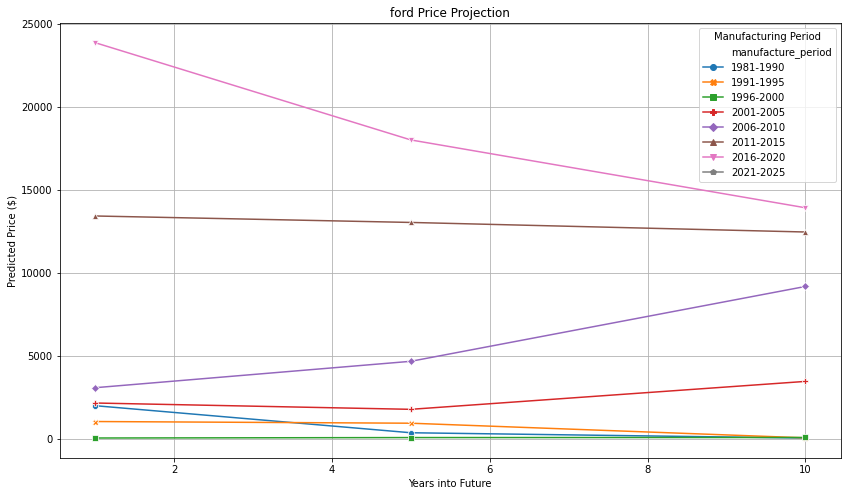

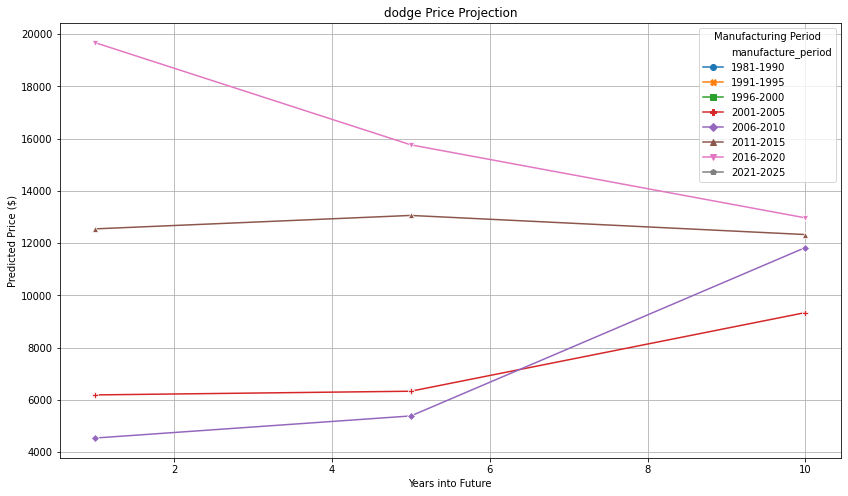

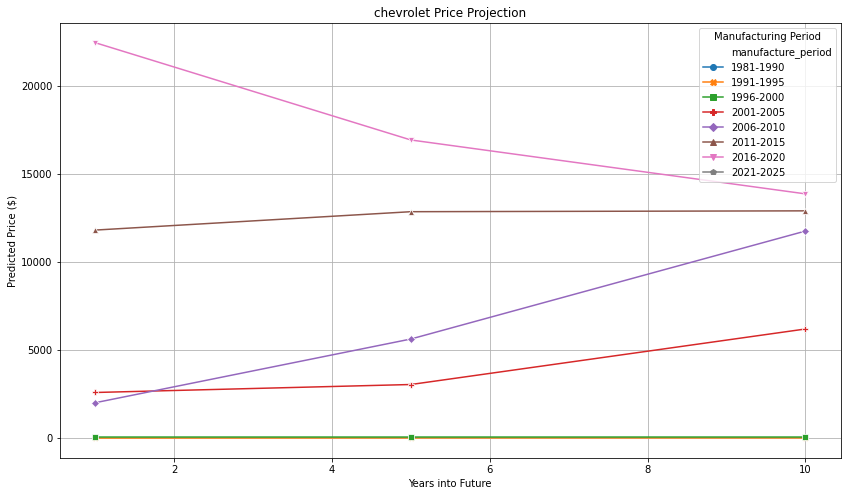

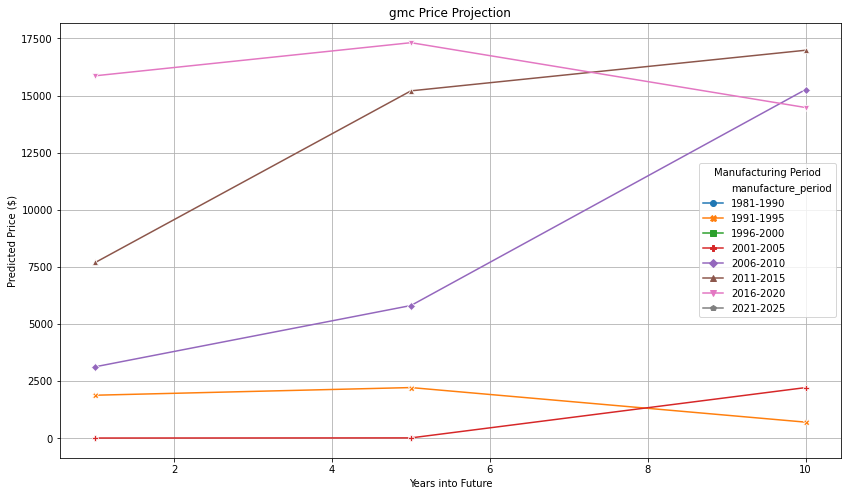

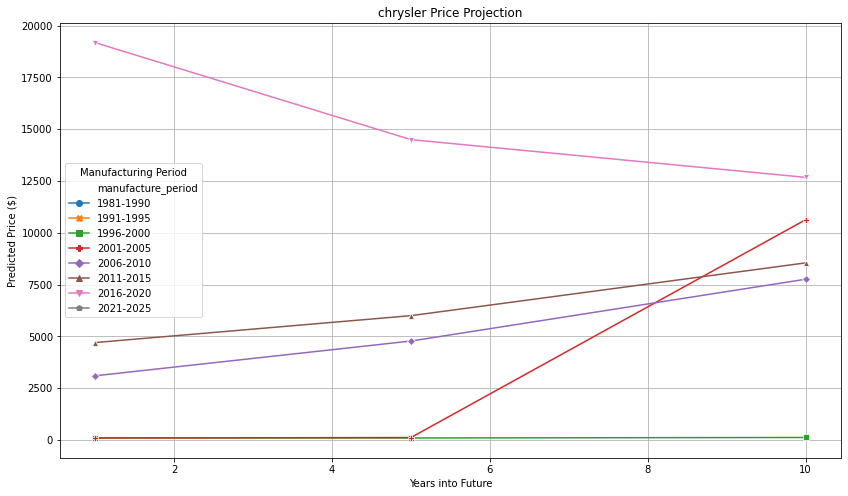

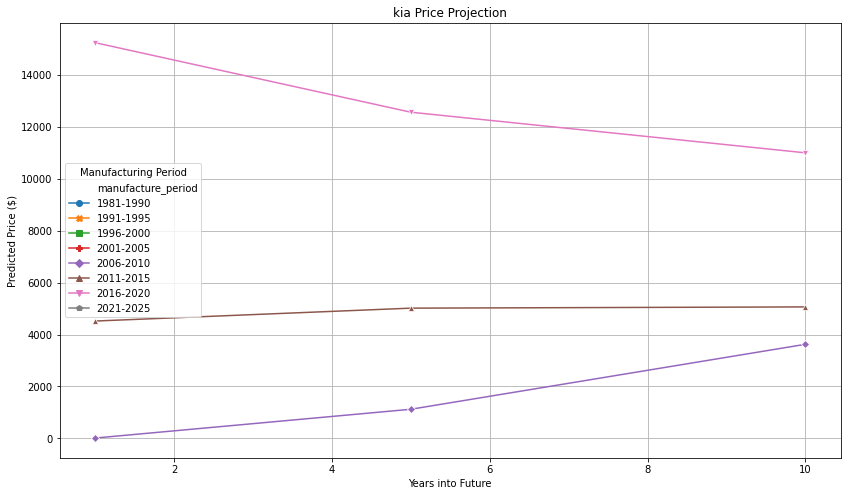

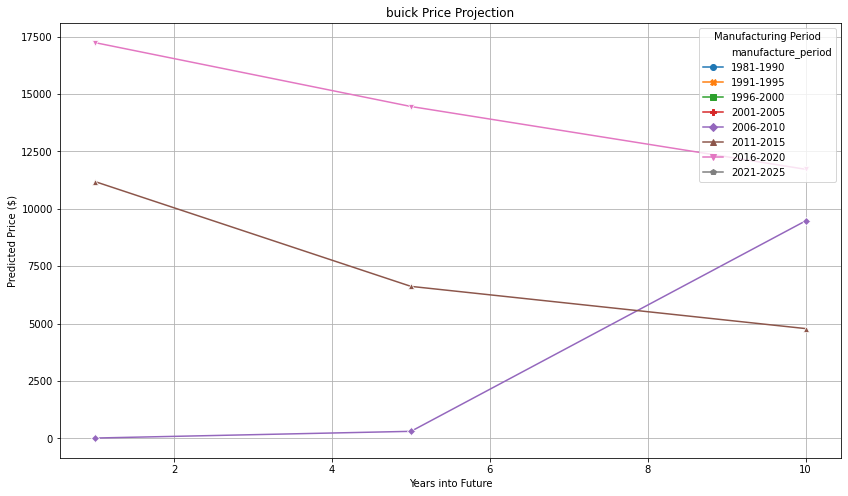

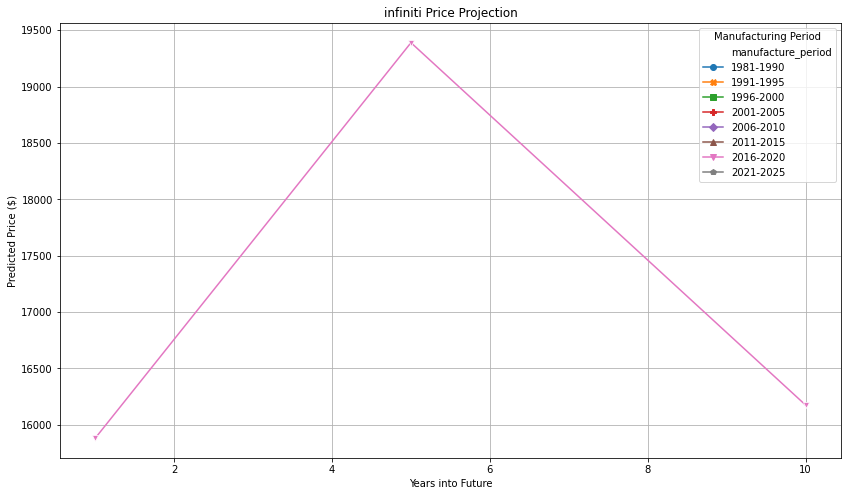

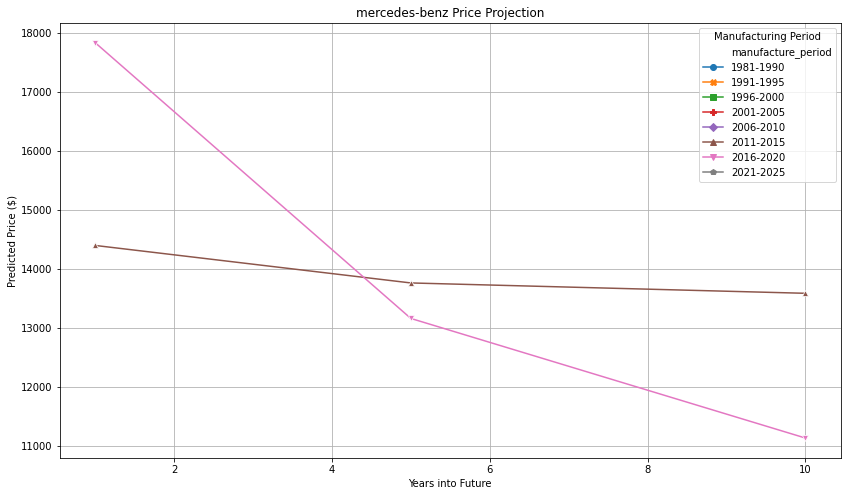

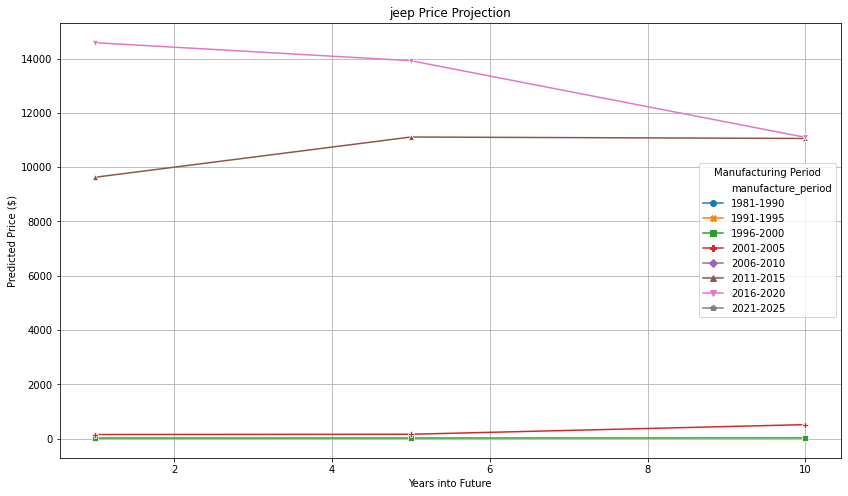

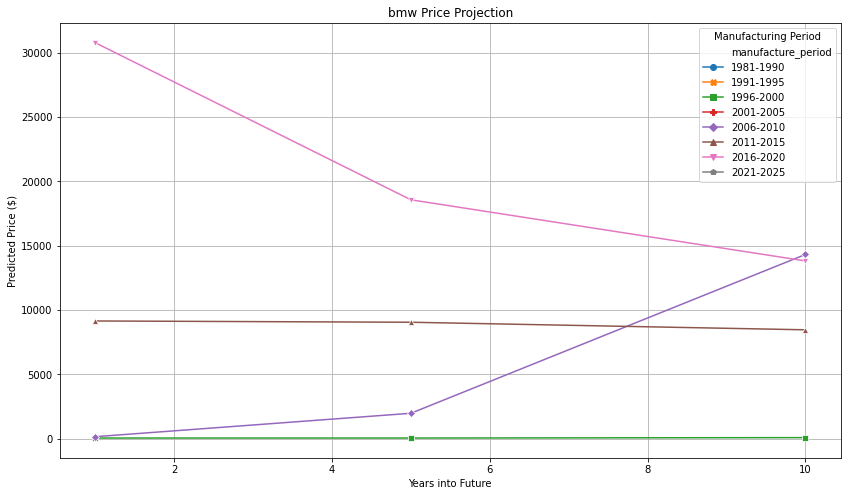

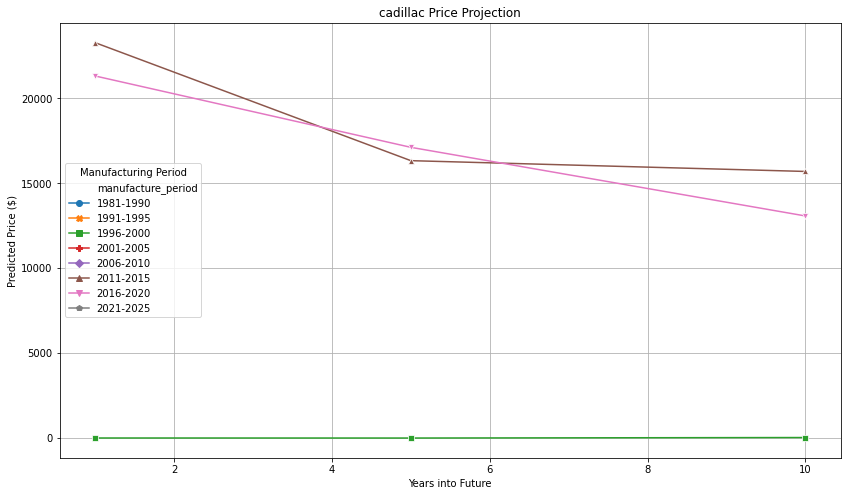

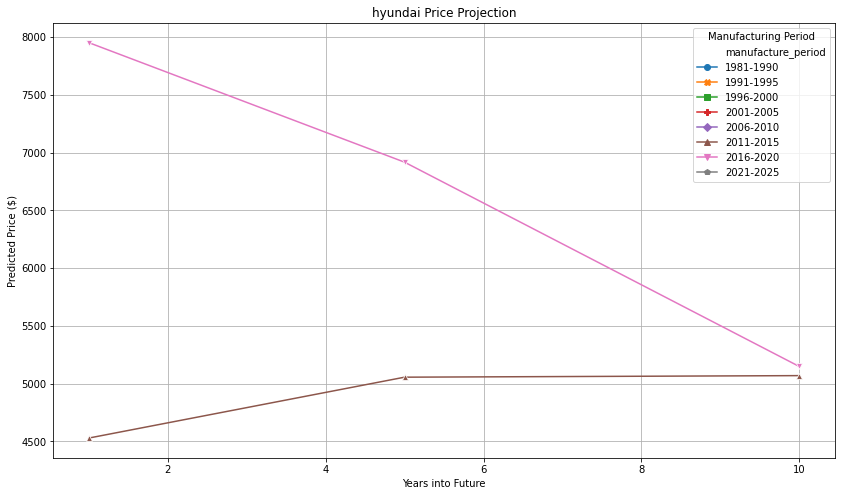

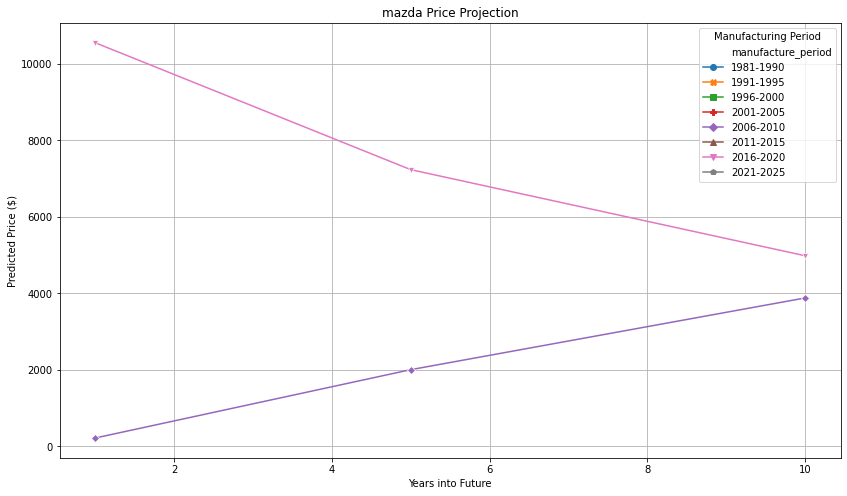

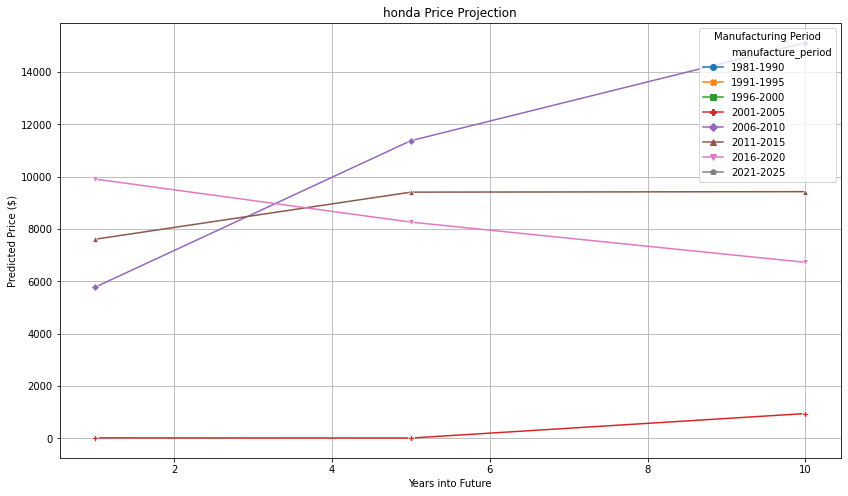

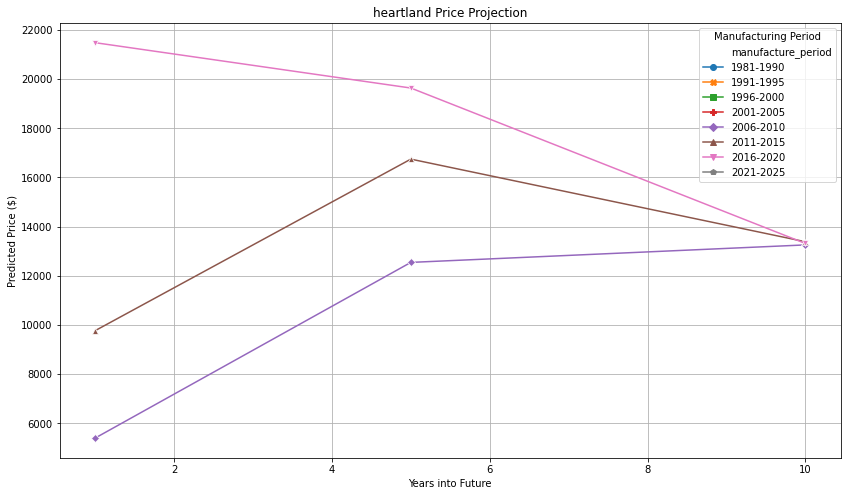

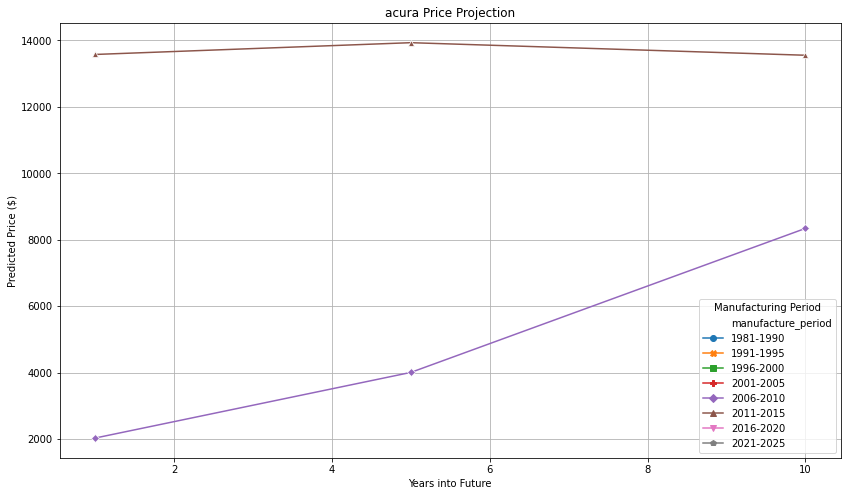

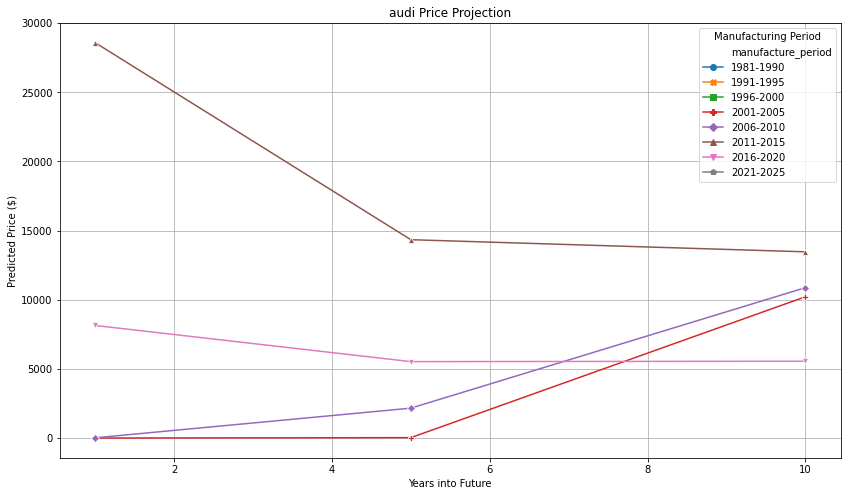

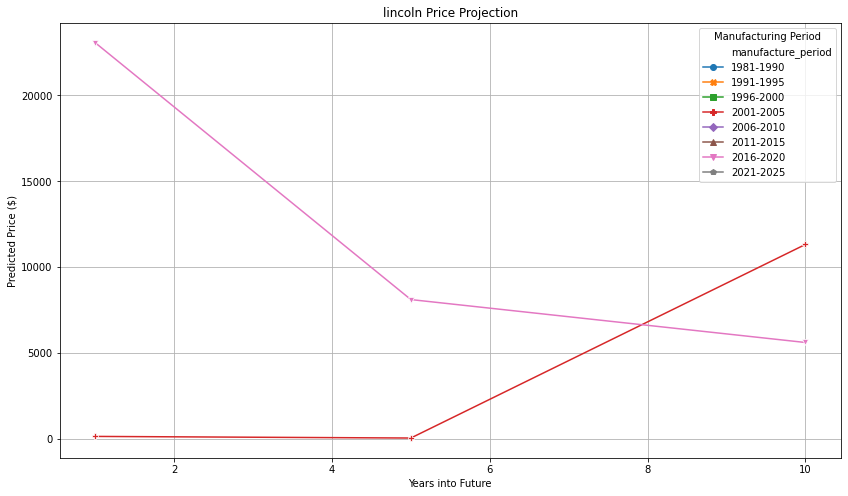

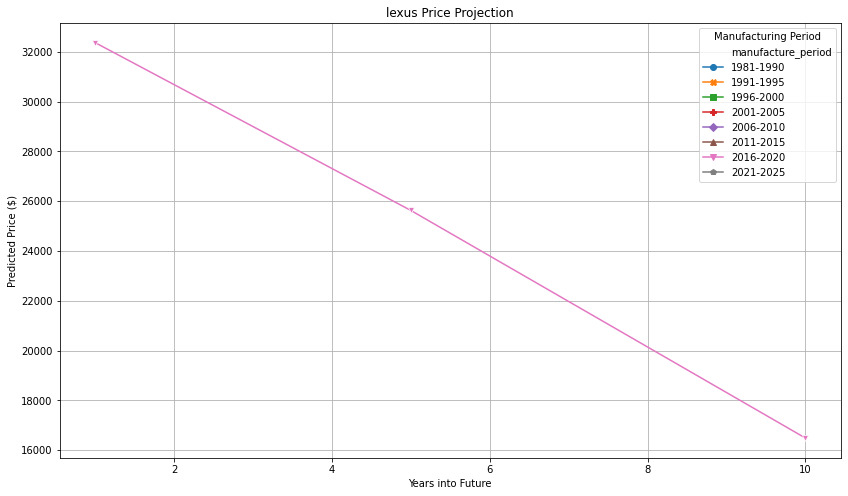

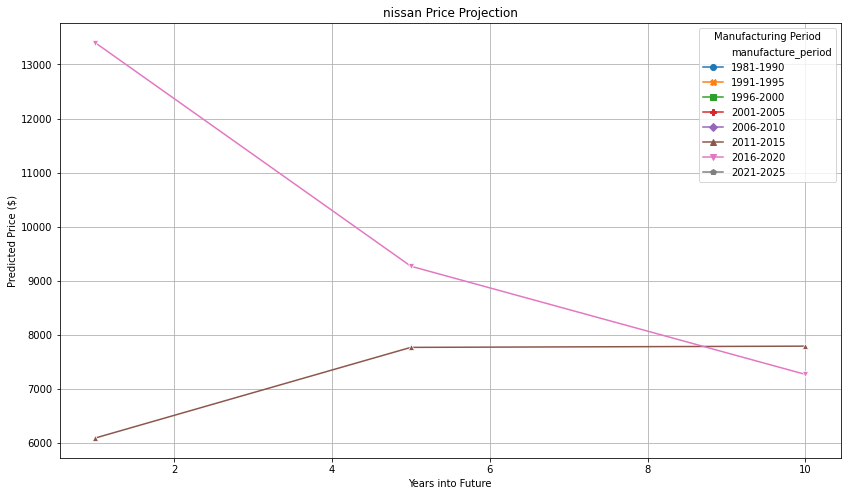

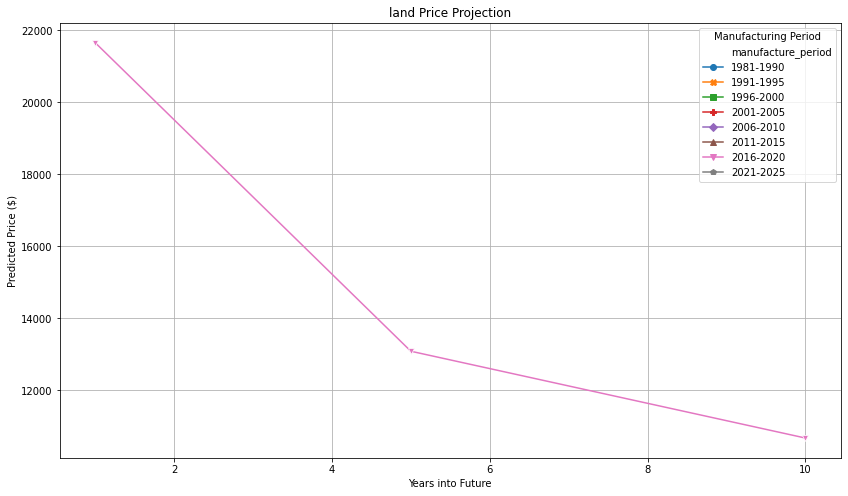

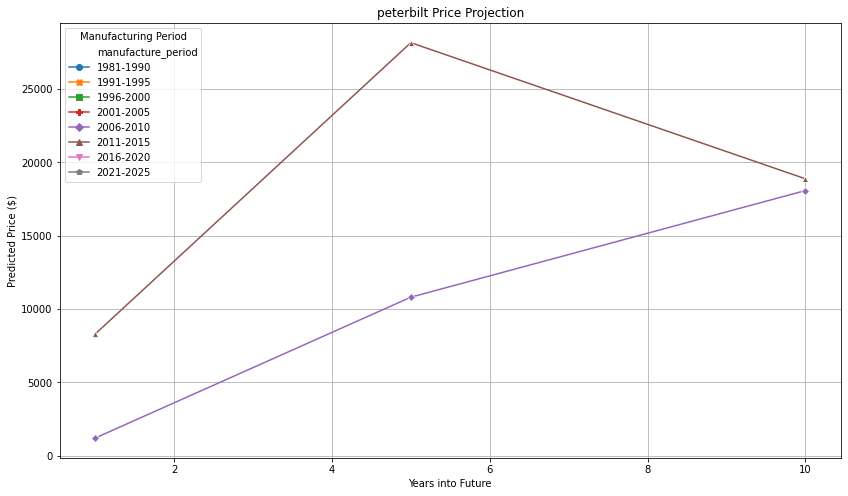


Model saved


In [2]:
import pandas as pd
import numpy as np
#essential tools for scaling, model building, splitting data, evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

#prepare data
try:
    df = pd.read_excel("FinalDataset_clean.xlsx")
    
    brand_counts = df['brand'].value_counts()
    valid_brands = brand_counts[brand_counts >= 2].index #only keep brands with at least 2 samples
    df = df[df['brand'].isin(valid_brands)]
    
    #time periods for pattern recognition
    current_year = datetime.now().year
    year_bins = [1980, 1990, 1995, 2000, 2005, 2010, 2015, 2020, current_year]
    year_labels = ['1981-1990', '1991-1995', '1996-2000', '2001-2005', 
                   '2006-2010', '2011-2015', '2016-2020', f'2021-{current_year}']
    df['manufacture_period'] = pd.cut(df['year'], bins=year_bins, labels=year_labels)#bin years helps with trend recognitiion
    
    print("\nAvailable brands:")
    print(df['brand'].unique())
except Exception as e:
    print(f"Data loading error: {str(e)}")
    exit()

# data preprocessing
numeric_features = ['year', 'mileage', 'Engine Displacement (L)', 'Cylinders']#numerical features
cat_features = ['brand', 'model', 'title_status', 'Drive Type', 
               'fueltype', 'Body Class', 'manufacture_period'] #strings

#pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])#standardizeing features

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #handle missing categories
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  #encode categories as numbers

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)])

#model pipeline for random forest 
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=150,
        max_depth=20,
        random_state=42,
        n_jobs=-1))
])

#test split
X = df.drop(['price', 'vin', 'lot', 'state', 'country', 'color', 'condition', 'Trim'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=df['brand']
)

#train model with data
print("\nTraining model...")
model.fit(X_train, y_train)

#evaluate the stranth of the model 
y_pred = model.predict(X_test)
print(f"\nModel Performance:")
print(f"MAE: ${mean_absolute_error(y_test, y_pred):,.2f}") #error for the dataset run
print(f"R²: {r2_score(y_test, y_pred):.2f}")  # the reliability of the model for the dataset

# Future prediction function
def predict_future_prices(years_ahead_list):
    current_year = datetime.now().year
    predictions = []
    
    for years_ahead in years_ahead_list:
        future_df = df.copy()
        
        #simulation for ageing cars
        future_df['year'] += years_ahead
        future_df['mileage'] += (12000 * years_ahead)  #12k miles assumption per year
        future_df['mileage'] = np.clip(future_df['mileage'], 0, 200000)  #unrealistic mileage cut
        
        #predict prices
        future_df['future_price'] = model.predict(future_df[X.columns])
        
        #aggregate results
        grouped = future_df.groupby(['brand', 'manufacture_period']).agg({
            'future_price': ['mean', 'median'],
            'mileage': 'mean',
            'Engine Displacement (L)': 'mean',
            'price': 'mean'
        }).reset_index()
        
        grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns]
        grouped['years_ahead'] = years_ahead
        predictions.append(grouped)
    
    return pd.concat(predictions)

#generate predictions
print("\nGenerating future price")
future_predictions = predict_future_prices([1, 5, 10]) #1,5,10 year predition
future_predictions.to_csv('future_price_predictions.csv', index=False)
print("\nPredictions saved")

#visual
def plot_predictions(brand):
    brand_data = future_predictions[future_predictions['brand'] == brand]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=brand_data,
        x='years_ahead',
        y='future_price_mean',
        hue='manufacture_period',
        style='manufacture_period',
        markers=True,
        dashes=False
    )
    plt.title(f'{brand} Price Projection')
    plt.xlabel('Years into Future')
    plt.ylabel('Predicted Price ($)')
    plt.legend(title='Manufacturing Period')
    plt.grid(True)
    plt.show()



if 'brand' in df.columns:
     #plot for each brand
    for brand in df['brand'].unique():
        plot_predictions(brand)
joblib.dump(model, 'used_car_price_predictor.pkl')
print("\nModel saved")

#sample prediction interface
def predict_price(car_details):
    try:
        input_data = pd.DataFrame([{
            'brand': car_details['brand'],
            'model': car_details['model'],
            'year': car_details['year'],
            'mileage': car_details['mileage'],
            'Engine Displacement (L)': car_details['displacement'],
            'Cylinders': car_details['cylinders'],
            'Drive Type': car_details['drive_type'],
            'fueltype': car_details['fuel_type'],
            'Body Class': car_details['body_class'],
            'title_status': car_details.get('title_status', 'clean'),
            'manufacture_period': pd.cut([car_details['year']], bins=year_bins, labels=year_labels)[0] #bin select for year of cart
        }])
        return model.predict(input_data)[0] #return predicted price
    except Exception as e:
            print(f"Prediction error: {str(e)}")
            return None
